In [1]:
from google.colab import drive
drive.mount("/content/drive/")

import os, sys
path = "/content/drive/My Drive"
sys.path.append(path)
os.chdir(path)

Mounted at /content/drive/


In [2]:
%cd Neural\ Network\ \&\ Deep\ Learning

/content/drive/My Drive/Neural Network & Deep Learning


In [3]:
from torchvision import models
model = models.resnet18(pretrained=True)
model.layer2[0]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

The following is our model!

In [4]:
import torch
import torch.nn.functional as F
import glob
import random
from torchsummary import summary
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from prefetch_generator import BackgroundGenerator


class SEBlock(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.globalavgpooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(c_in, max(1, c_in // 16))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(max(1, c_in // 16), c_in)
        self.sigmoid = nn.Sigmoid()
        self.c_in = c_in
    
    def forward(self, x):
        assert self.c_in == x.size(1)
        x = self.globalavgpooling(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)
        return x


class SERes18(nn.Module):
    def __init__(self, num_class=751):
        super().__init__()
        model = models.resnet18(pretrained=True)
        self.conv0 = model.conv1
        self.bn0 = model.bn1
        self.relu0 = model.relu
        self.pooling0 = model.maxpool
        self.basicBlock11 = model.layer1[0]
        self.seblock1 = SEBlock(64)
        self.basicBlock12 = model.layer1[1]
        self.seblock2 = SEBlock(64)
        self.basicBlock21 = model.layer2[0]
        # self.seblock3 = SEBlock(128)
        self.basicBlock22 = model.layer2[1]
        self.seblock4 = SEBlock(128)
        self.basicBlock31 = model.layer3[0]
        # self.seblock5 = SEBlock(256)
        self.basicBlock32 = model.layer3[1]
        self.seblock6 = SEBlock(256)
        self.basicBlock41 = model.layer4[0]
        # self.seblock7 = SEBlock(512)
        self.basicBlock42 = model.layer4[1]
        self.seblock8 = SEBlock(512)
        self.avgpooling = model.avgpool
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.pooling0(x)
        branch1 = x
        x = self.basicBlock11(x)
        scale1 = self.seblock1(x)
        x = scale1 * x + branch1
        branch2 = x

        x = self.basicBlock12(x)
        scale2 = self.seblock2(x)
        x = scale2 * x + branch2

        x = self.basicBlock21(x)

        branch4 = x
        x = self.basicBlock22(x)

        scale4 = self.seblock4(x)
        x = scale4 * x + branch4

        x = self.basicBlock31(x)

        branch6 = x
        x = self.basicBlock32(x)
        scale6 = self.seblock6(x)
        x = scale6 * x + branch6

        x = self.basicBlock41(x)

        branch8 = x
        x = self.basicBlock42(x)
        scale8 = self.seblock8(x)
        x = scale8 * x + branch8

        x = self.avgpooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

my_model = SERes18().cuda()
summary(my_model, input_size=(3, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 32]           9,408
       BatchNorm2d-2           [-1, 64, 64, 32]             128
              ReLU-3           [-1, 64, 64, 32]               0
         MaxPool2d-4           [-1, 64, 32, 16]               0
            Conv2d-5           [-1, 64, 32, 16]          36,864
       BatchNorm2d-6           [-1, 64, 32, 16]             128
              ReLU-7           [-1, 64, 32, 16]               0
            Conv2d-8           [-1, 64, 32, 16]          36,864
       BatchNorm2d-9           [-1, 64, 32, 16]             128
             ReLU-10           [-1, 64, 32, 16]               0
       BasicBlock-11           [-1, 64, 32, 16]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 4]             260
             ReLU-14                   

In [29]:
class SEDense18(nn.Module):
    def __init__(self, num_class=751):
        super().__init__()
        model = models.resnet18(pretrained=True)
        self.conv0 = model.conv1
        self.bn0 = model.bn1
        self.relu0 = model.relu
        self.pooling0 = model.maxpool
        self.basicBlock11 = model.layer1[0]
        self.seblock1 = SEBlock(64)

        self.basicBlock12 = model.layer1[1]
        self.seblock2 = SEBlock(64)

        self.basicBlock21 = model.layer2[0]
        self.seblock3 = SEBlock(128)
        self.ancillaryconv3 = nn.Conv2d(64, 128, 1, 2, 0)

        self.basicBlock22 = model.layer2[1]
        self.seblock4 = SEBlock(128)

        self.basicBlock31 = model.layer3[0]
        self.seblock5 = SEBlock(256)
        self.ancillaryconv5 = nn.Conv2d(128, 256, 1, 2, 0)

        self.basicBlock32 = model.layer3[1]
        self.seblock6 = SEBlock(256)

        self.basicBlock41 = model.layer4[0]
        self.seblock7 = SEBlock(512)
        self.ancillaryconv7 = nn.Conv2d(256, 512, 1, 2, 0)

        self.basicBlock42 = model.layer4[1]
        self.seblock8 = SEBlock(512)

        self.avgpooling = model.avgpool
        # self.fc = nn.Linear(512, num_class)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_class),
        )
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.pooling0(x)
        branch1 = x
        x = self.basicBlock11(x)
        scale1 = self.seblock1(x)
        x = scale1 * x + branch1

        branch2 = x
        x = self.basicBlock12(x)
        scale2 = self.seblock2(x)
        x = scale2 * x + branch2

        branch3 = x
        x = self.basicBlock21(x)
        scale3 = self.seblock3(x)
        x = scale3 * x + self.ancillaryconv3(branch3)

        branch4 = x
        x = self.basicBlock22(x)
        scale4 = self.seblock4(x)
        x = scale4 * x + branch4

        branch5 = x
        x = self.basicBlock31(x)
        scale5 = self.seblock5(x)
        x = scale5 * x + self.ancillaryconv5(branch5)

        branch6 = x
        x = self.basicBlock32(x)
        scale6 = self.seblock6(x)
        x = scale6 * x + branch6

        branch7 = x
        x = self.basicBlock41(x)
        scale7 = self.seblock7(x)
        x = scale7 * x + self.ancillaryconv7(branch7)

        branch8 = x
        x = self.basicBlock42(x)
        scale8 = self.seblock8(x)
        x = scale8 * x + branch8

        x = self.avgpooling(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        x = self.classifier(x)

        return x

my_model = SEDense18().cuda()
summary(my_model, input_size=(3, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 32]           9,408
       BatchNorm2d-2           [-1, 64, 64, 32]             128
              ReLU-3           [-1, 64, 64, 32]               0
         MaxPool2d-4           [-1, 64, 32, 16]               0
            Conv2d-5           [-1, 64, 32, 16]          36,864
       BatchNorm2d-6           [-1, 64, 32, 16]             128
              ReLU-7           [-1, 64, 32, 16]               0
            Conv2d-8           [-1, 64, 32, 16]          36,864
       BatchNorm2d-9           [-1, 64, 32, 16]             128
             ReLU-10           [-1, 64, 32, 16]               0
       BasicBlock-11           [-1, 64, 32, 16]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 4]             260
             ReLU-14                   

In [30]:
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, image_path, label_path, transform, prefix="Market1501/bounding_box_train/"):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform
        self.prefix = prefix
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image = self.prefix + self.image_path[idx]
        label = self.label_path[idx]
        image = Image.open(image).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).int()


class LabelSmoothing(nn.Module):
    """ NLL loss with label smoothing. """

    def __init__(self, smoothing=0.1):
        """ Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        target = target.long()
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [31]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

def get_image_path(folder):
    image_path = glob.glob(folder + "/*.jpg")
    image_path = sorted(image_path)
    image_path = list(map(lambda x: x.split("/")[-1], image_path))
    return image_path


def get_labels(image_path):
    class_idx = 0
    labels = list()
    cur_person = None
    for path in image_path:
        if path.split("_")[0] != cur_person:
            cur_person = path.split("_")[0]
            labels.append(class_idx)
            class_idx += 1
        else:
            labels.append(class_idx)
    return labels


def load_dataset(image_path, label_path):
    transform = transforms.Compose([
           transforms.Resize((128, 64)),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
           transforms.RandomErasing(),
    ])
    the_dataset = MyDataset(image_path, label_path, transform)
    return the_dataset


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print("Checkpoint saved!")


def load_model(num_class, checkpoint, lr, device="cuda:0", is_dense=True, with_generated=False):
    if is_dense:
        model = SEDense18(num_class).to(device)
    else:
        model = SERes18(num_class).to(device)
    if checkpoint:
        if os.path.exists(checkpoint):
            state_dict = torch.load(checkpoint)
            model.load_state_dict(state_dict, strict=False)
            print("Model Successfully Loaded!")
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-4)
    if with_generated:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
        loss = LSROloss()
    else:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.5)
        loss = LabelSmoothing()
    return model, optimizer, lr_scheduler, loss


def train(folder, epochs=20, device="cuda:0", is_dense=True):
    image_path = get_image_path(folder)
    labels = get_labels(image_path)
    the_dataset = load_dataset(image_path, labels)
    model, optimizer, lr_scheduler, loss_function = load_model(max(labels)-min(labels)+1, None, 0.1, device, is_dense)
    record_losses = list()
    for epoch in range(epochs):
        dataloader = DataLoaderX(the_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=8)
        iterator = tqdm(dataloader)
        for images, labels in iterator:
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            classification = model(images)
            loss = loss_function(classification, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            status = "epoch: {:d}, learning rate: {:.5f}, loss: {:.5f}".format(epoch, lr_scheduler.get_last_lr()[0], loss)
            iterator.set_description(status)
            record_losses.append(loss.item())
    if is_dense:
        save_model(model, "seDense18_checkpoint.pth")
    else:
        save_model(model, "seRes18_checkpoint.pth")
    return record_losses


def plot_losses(record_losses):
    plt.figure()
    plt.plot(record_losses)
    plt.xlabel("iterations")
    plt.ylabel("label smoothing loss")
    plt.title("training loss")
    plt.grid()
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 19, learning rate: 0.00625, loss: 1.48160: 100%|██████████| 203/203 [00:29<00:00,  6.99it/s]


Checkpoint saved!


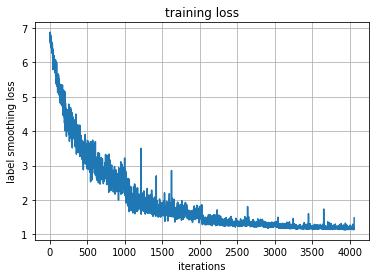

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
record_losses = train("Market1501/bounding_box_train", device=device, is_dense=True)
plot_losses(record_losses)

In [32]:
class LSROloss(nn.Module):
    def __init__(self): 
        super(LSROloss, self).__init__()
    
    def forward(self, input, target, flg): # while flg means the flag(=0 for true data and 1 for generated data)  batchsize*1
        if input.dim()>2:                   # N defines the number of images, C defines channels,  K class in total
            input=input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input=input.transpose(1,2)            # N,C,H*W => N,H*W,C
            input=input.contiguous().view(-1,input.size(2))  # N,H*W,C => N*H*W,C
       
        # normalize input
        maxRow, _ = torch.max(input.data, 1)   # outputs.data return the index of the biggest value in each row
        maxRow = maxRow.unsqueeze(1)
        input.data = input.data - maxRow
        
        target = target.view(-1,1)      # batchsize*1
        flg = flg.view(-1,1) 
        flos = F.log_softmax(input, dim=-1)    #     batchsize*751
        flos = torch.sum(flos,1) / flos.size(1)       # N*1  get average      gan loss    
        logpt = F.log_softmax(input, dim=-1)   # size: batchsize*751
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)           # N*1     original loss   
        flg = flg.view(-1) 
        flg = flg.type(torch.cuda.FloatTensor)
        loss = -1*logpt*(1-flg) - flos*flg
        return loss.mean()


class GANDataset(Dataset):
    def __init__(self, real_image_path, generated_image_path, labels_real, labels_generated, transforms, 
           prefix1="Market1501/bounding_box_train/", prefix2="Person-reid-GAN-pytorch/DCGAN-tensorflow/gen_market/"):
        super().__init__()
        self.labels = labels_real + labels_generated
        self.all_image_path = real_image_path + generated_image_path
        self.transforms = transforms
        self.prefix1 = prefix1
        self.prefix2 = prefix2
        self.length = len(labels_real)
    
    def __len__(self):
        return len(self.all_image_path)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        if idx < self.length:
            image = self.prefix1 + self.all_image_path[idx]
            flag = 0
        else:
            image = self.prefix2 + self.all_image_path[idx]
            flag = 1
        image = Image.open(image).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        return image, torch.tensor(label).long(), torch.tensor(flag).int()


def load_dataset_all(image_path_real, image_path_generated, labels_real, labels_generated):
    transform = transforms.Compose([
           # transforms.Resize((128, 64)),
           transforms.RandomCrop((128, 64), padding=4),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
           # transforms.RandomErasing(),
    ])
    dataset = GANDataset(image_path_real, image_path_generated, labels_real, labels_generated, transform)
    return dataset


def get_generated_labels(generated_image_path):
    labels = list(map(lambda x: int(x.split("_")[-1].strip(".jpg")), generated_image_path))
    return labels

def train_with_generated(folder_real, folder_generated, epochs=25, device="cuda:0", is_dense=True):
    real_image_path = get_image_path(folder_real)
    generated_image_path = get_image_path(folder_generated)
    generated_image_path_sampled = random.sample(generated_image_path, 960)
    labels = get_labels(real_image_path)
    generated_labels = get_generated_labels(generated_image_path_sampled)
    the_dataset = load_dataset_all(real_image_path, generated_image_path_sampled, labels, generated_labels)
    model, optimizer, lr_scheduler, loss_function = load_model(max(labels)-min(labels)+1, None, 0.01, device, is_dense, True)
    record_losses = list()
    for epoch in range(epochs):
        dataloader = DataLoaderX(the_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=8)
        iterator = tqdm(dataloader)
        for images, labels, flags in iterator:
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            flags = flags.to(device)
            classification = model(images)
            loss = loss_function(classification, labels, flags)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            status = "epoch: {:d}, learning rate: {:.5f}, loss: {:.5f}".format(epoch, lr_scheduler.get_last_lr()[0], loss)
            iterator.set_description(status)
            record_losses.append(loss.item())
    if is_dense:
        save_model(model, "seDense18_dcgan_checkpoint.pth")
    else:
        save_model(model, "seRes18_dcgan_checkpoint.pth")
    return record_losses

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 24, learning rate: 0.00250, loss: 2.23161: 100%|██████████| 218/218 [00:23<00:00,  9.31it/s]


Checkpoint saved!


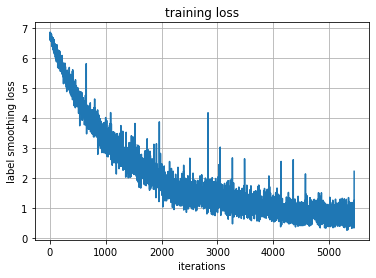

In [33]:
folder_real = "Market1501/bounding_box_train"
folder_generated = "Person-reid-GAN-pytorch/DCGAN-tensorflow/gen_market"
record_losses_with_gan = train_with_generated(folder_real, folder_generated)
plot_losses(record_losses_with_gan)

In [34]:
def test(folder, model_path, device="cuda:0"):
    model = SEDense18(752).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    image_path = get_image_path(folder)
    labels = get_labels(image_path)
    the_dataset = load_dataset(image_path, labels)
    dataloader = DataLoaderX(the_dataset, shuffle=False, batch_size=64, pin_memory=True, num_workers=8)
    isSame = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        classification = model(images).max(1)[1]
        isSame += torch.eq(classification, labels).count_nonzero().item()
    return isSame

In [35]:
test("Market1501/bounding_box_train", "seDense18_dcgan_checkpoint.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 203/203 [00:22<00:00,  9.20it/s]


286

The following is the baseline!

In [18]:
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, c_in, c_out,is_downsample=False):
        super(BasicBlock,self).__init__()
        self.is_downsample = is_downsample
        if is_downsample:
            self.conv1 = nn.Conv2d(c_in, c_out, 3, stride=2, padding=1, bias=False)
        else:
            self.conv1 = nn.Conv2d(c_in, c_out, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(c_out,c_out,3,stride=1,padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        if is_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=2, bias=False),
                nn.BatchNorm2d(c_out)
            )
        elif c_in != c_out:
            self.downsample = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=1, bias=False),
                nn.BatchNorm2d(c_out)
            )
            self.is_downsample = True

    def forward(self,x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        if self.is_downsample:
            x = self.downsample(x)
        return F.relu(x.add(y),True)

def make_layers(c_in,c_out,repeat_times, is_downsample=False):
    blocks = []
    for i in range(repeat_times):
        if i ==0:
            blocks += [BasicBlock(c_in,c_out, is_downsample=is_downsample),]
        else:
            blocks += [BasicBlock(c_out,c_out),]
    return nn.Sequential(*blocks)

class Net(nn.Module):
    def __init__(self, num_classes=751 ,reid=False):
        super(Net,self).__init__()
        # 3 128 64
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Conv2d(32,32,3,stride=1,padding=1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,padding=1),
        )
        # 32 64 32
        self.layer1 = make_layers(64,64,2,False)
        # 32 64 32
        self.layer2 = make_layers(64,128,2,True)
        # 64 32 16
        self.layer3 = make_layers(128,256,2,True)
        # 128 16 8
        self.layer4 = make_layers(256,512,2,True)
        # 256 8 4
        self.avgpool = nn.AvgPool2d((8,4),1)
        # 256 1 1 
        self.reid = reid
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        # B x 128
        if self.reid:
            x = x.div(x.norm(p=2,dim=1,keepdim=True))
            return x
        # classifier
        x = self.classifier(x)
        return x

baseline_model = Net().cuda()
summary(baseline_model, input_size=(3, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 64]           1,792
       BatchNorm2d-2          [-1, 64, 128, 64]             128
              ReLU-3          [-1, 64, 128, 64]               0
         MaxPool2d-4           [-1, 64, 64, 32]               0
            Conv2d-5           [-1, 64, 64, 32]          36,864
       BatchNorm2d-6           [-1, 64, 64, 32]             128
              ReLU-7           [-1, 64, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          36,864
       BatchNorm2d-9           [-1, 64, 64, 32]             128
       BasicBlock-10           [-1, 64, 64, 32]               0
           Conv2d-11           [-1, 64, 64, 32]          36,864
      BatchNorm2d-12           [-1, 64, 64, 32]             128
             ReLU-13           [-1, 64, 64, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
def load_baseline_model(num_class, checkpoint, lr, device="cuda:0"):
    model = Net(num_class).to(device)
    if checkpoint:
        if os.path.exists(checkpoint):
            state_dict = torch.load(checkpoint)
            model.load_state_dict(state_dict, strict=False)
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.5)
    loss = LabelSmoothing()
    return model, optimizer, lr_scheduler, loss


def train_baseline(folder, epochs=20, device="cuda:0"):
    image_path = get_image_path(folder)
    labels = get_labels(image_path)
    the_dataset = load_dataset(image_path, labels)
    model, optimizer, lr_scheduler, loss_function = load_baseline_model(max(labels)-min(labels)+1, None, 0.1, device)
    record_losses = list()
    for epoch in range(epochs):
        dataloader = DataLoaderX(the_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=8)
        iterator = tqdm(dataloader)
        for images, labels in iterator:
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            classification = model(images)
            loss = loss_function(classification, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            status = "epoch: {:d}, learning rate: {:.5f}, loss: {:.5f}".format(epoch, lr_scheduler.get_last_lr()[0], loss)
            iterator.set_description(status)
            record_losses.append(loss.item())
    return record_losses

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 19, learning rate: 0.00625, loss: 2.66432: 100%|██████████| 203/203 [00:37<00:00,  5.40it/s]


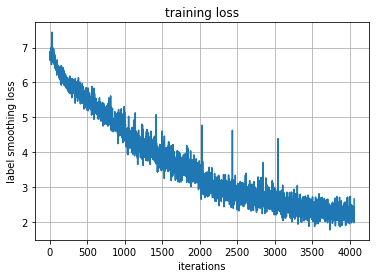

In [ ]:
folder_real = "Market1501/bounding_box_train"
record_losses_baseline = train_baseline(folder_real)
plot_losses(record_losses_baseline)

In [25]:
def test(folder, model_path, device="cuda:0"):
    model = Net(752).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    image_path = get_image_path(folder)
    labels = get_labels(image_path)
    the_dataset = load_dataset(image_path, labels)
    dataloader = DataLoaderX(the_dataset, shuffle=False, batch_size=64, pin_memory=True, num_workers=8)
    isSame = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        classification = model(images).max(1)[1]
        isSame += torch.eq(classification, labels).count_nonzero().item()
    return isSame

In [26]:
test("Market1501/bounding_box_train", "ckpt.t7")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 203/203 [00:17<00:00, 11.92it/s]


19